In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas_datareader as web
import yfinance as yf
import mplfinance as mpf

plt.style.use('seaborn')

# start date for API requests
start = '2020-01-01'

ModuleNotFoundError: No module named 'seaborn'

# Basic OHLC DATA GRAB

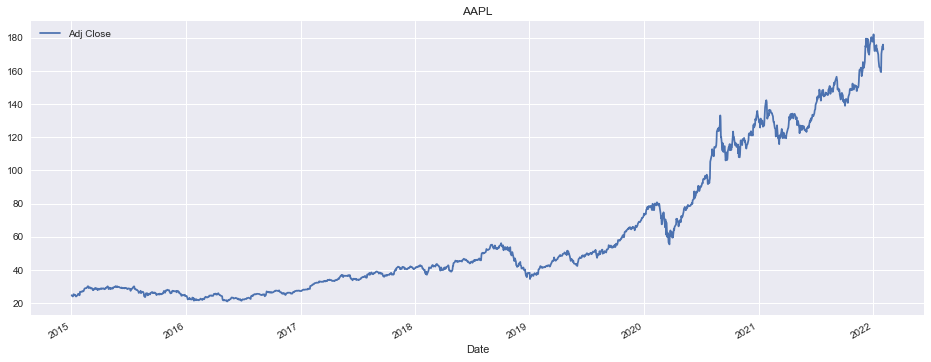

In [ ]:
def get_stock(stock, start, end=None, return_name=True):     
    '''return a tuple containing stock name and OHLC data 
    sourced from a pandas_datareader and the yahoo API
    
    INPUTS: 
    stock: the ticker (a string)
    start/end: specified start and end (date format string)
    
    for certain purposes, returning the frame only might make sense. 
    This is possible using the return_name argument'''
    try:
        frame = web.DataReader(name=f"{stock}", data_source='yahoo', start=start, end=end)
    
        if return_name == True:
            return stock, frame
        else:
            return frame
    except:
        pass
    
# ## example
a=get_stock('AAPL', start='2015-01-01')
a[1]['Adj Close'].plot(figsize=(16,6))
plt.title(a[0])
plt.legend()
plt.show()

# Exponential or Simple moving averages; named Series; return, plot, or add columns;

In [ ]:
def add_ma(df,
           ma=20,
           col='Adj Close',
           plot_ma=False,
           add_col=False,
           return_ma=True,
           name=None,
           kind='s',
#            plot_args = dict(),
           *args, ### MORE TO LEARN ABOUT *ARGS AND **KWARGS
           **kwargs
          ):
    '''calculate a moving average
    
    INPUTS:
    df: DataFrame; a stock dataframe
    ma: integer; the interval with which to calculate the moving average
    col: string; the column from which to calculate the moving average
    plot_ma: bool; whether to call plt.plot on the moving average
    add_col: bool; whether to add the resulting MA to `df`
    return_ma: bool; whether to return the resulting MA to be used elsewhere
    name:None or string; whether to name the returned or plotted column (inputs label to plot call; name to Series.name)
    '''
    
    ### Interpreting `name` argument and setting it (if not passed)
    if not name:
        name=f'{kind.upper()}MA{ma}'
    else:
        assert isinstance(name, str), 'name must be a string'

       
    ### Calculating SMA from `ma` argument
    if kind.casefold() == 's':
        output = df[col].rolling(ma).mean()
    
    ### Calculating EMA
    elif kind.casefold() == 'e':
        output = df[col].ewm(span=ma, adjust=False).mean()
    
    ### Assigning name to series (for matplotlib and pandas)
    output.name = f'{name}MA{kind.upper()}{ma}'
    
    ### interpreting plot_ma statement
    if plot_ma == True:
        plt.plot(output, label = name, lw=1)

        ### interpreting add_col statement
    if add_col==True:
        df[name] = output
    
    ### Finally, if return_ma==True, return the Series (with name)
    if return_ma==True:
        return output
    
# ### example:
a=get_stock('AAPL', start='2020-01-01')
### RETURN MA AS SERIES
#simply return the series
add_ma(a[1])
add_ma(a[1], name=a[0])

Date
2020-01-02         NaN
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
                ...   
2022-01-28    170.0010
2022-01-31    169.8615
2022-02-01    169.4915
2022-02-02    169.2985
2022-02-03    169.1975
Name: AAPLMAS20, Length: 528, dtype: float64

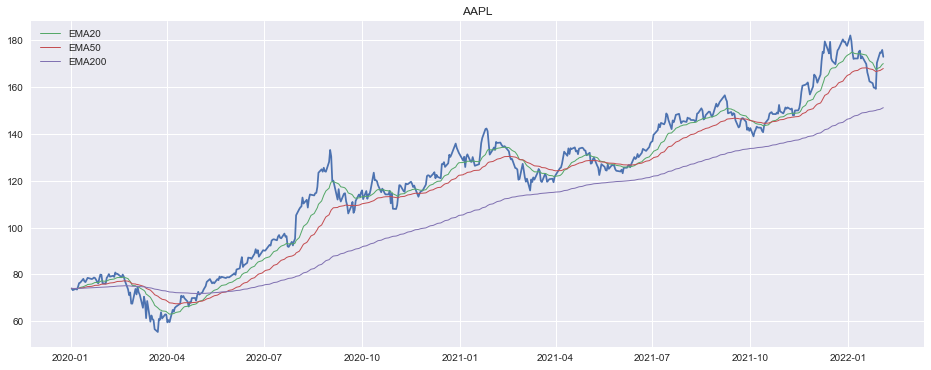

In [ ]:
#### PLOTTING DIRECTLY
#don't return the series but simply plot
# instantiate a figure
plt.figure(figsize=(16,6))
plt.title(a[0])
# plot original sales
plt.plot(a[1]['Adj Close'])
# add default (MA20)
add_ma(a[1], plot_ma=True, kind='e', return_ma=False)
# add MA50
add_ma(a[1], ma=50, plot_ma=True,kind='e', return_ma=False)
# add MA200
add_ma(a[1], 200, plot_ma=True, kind='e', return_ma=False)
plt.legend()
plt.show()

# BOLLINGER BANDS

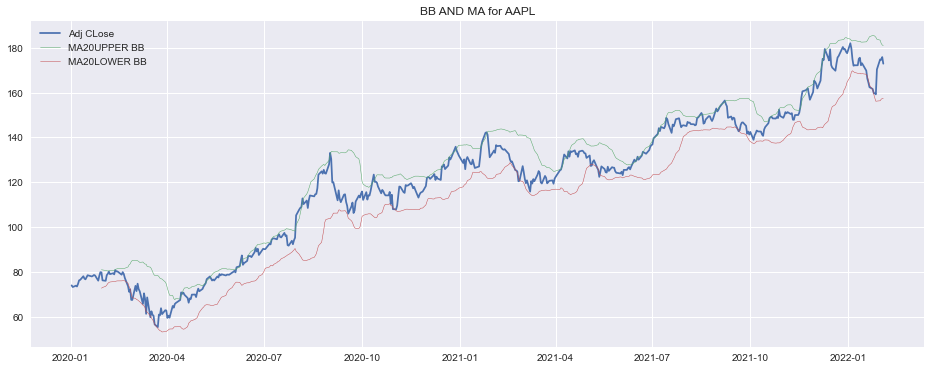

In [ ]:
def add_bb(df, 
           col='Adj Close', 
           buffer=2, 
           ma=20, 
           add_std_col=False, 
           add_ma_col=False,
           add_bb_cols=False,
           plot_std=False,
           plot_ma=False, 
           plot_bb=False,
           return_bb=True
#            plot_intercepts=False,
          ):
        
    '''df: the dataframe from which to calculate the moving average
    col: the column from which to calculate the moving average
    buffer: the number of standard deviations from which to calculate the bollinger bands
    MA: the number of days in the moving average
    add_dev: whether to add the SMA's standard deviation as a column to the dataframe
    plot: whether or not to call the SMA plot function'''
    
    #### DEFINE COLUMNS
   # the simple moving average returned from add_ma
    sma = add_ma(df, col=col, ma=ma, plot_ma=plot_ma, add_col=add_ma_col, return_ma=True)
    
    # the standard deviation from the mean for the same window
    std_sma = df[col].rolling(window=ma).std() 
    
    upper = sma + (std_sma * buffer)
    lower= sma - (std_sma * buffer)
    
    if add_std_col==True:
        df[f'{ma}STD'] = df[col].rolling(window=ma).std() 
    
    if plot_bb==True:  
        plt.plot(upper, label = f'MA{ma}UPPER BB', lw=0.5)  
        plt.plot(lower, label = f'MA{ma}LOWER BB', lw=0.5)
    
    if add_bb_cols==True:
        df['Upper'], df['Lower'] = upper, lower
        
    if return_bb==True:
        return upper, lower

#     ### EXAMPLE
plt.figure(figsize=(16,6))
plt.title(f'BB AND MA for {a[0]}')
plt.plot(a[1]['Adj Close'], label='Adj CLose')
add_bb(a[1], plot_bb=True, plot_ma=False, return_bb=False)
plt.legend()
plt.show()


# TREND REVERSAL FUNCTION

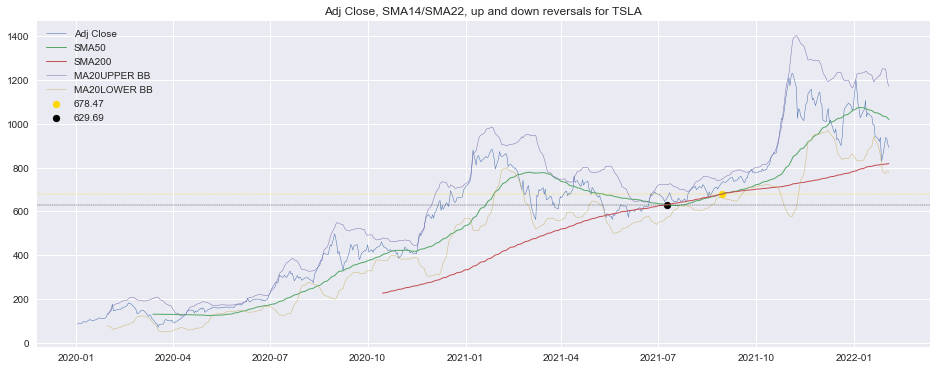

In [ ]:
def find_gold(df, 
              col1='SMA20', 
              col2='SMA200',
              plot_ups=False, 
              plot_downs=False,
              return_ups=True,
              return_downs=False,
              *args, 
              **kwargs, ## note feb 2022 -- more to learn, here.
             ):
    '''INPUTS:
        DFS: Dataframe OF OHLC DATA
        MA1, MA2: VECTORS FROM WHICH TO  up-/down-trends
        PLOT_UPS/DOWNS: WHETHER TO PLOT THE VALUES USING MATPLOTLIB
        RETURN_UPS/DOWNS: WHETHER TO RETURN DATETIME INDEX AND VALUE OF REVERSAL MOMENTS
        
    '''  

    # two columns for comparison.
    ma1 = df[col1]
    ma2 = df[col2]
    
    # container for golden cross values for this stock; a list of tuples.
    up_reversal = []
    down_reversal = []
    #[x[0] for x in up_reversal] = index
    #[x[1] for x in up_reversal] = `col1` (the short) at up_reversal
    
    
    #### CROSS LOGIC     
    # instantiate an down_ind indicator; WHEN MA1<MA2. 
    down_ind = None
    up_ind = None
    # iterate through the timeseries 
    # at any given datetime index, if the 20MA is above the 200MA  
      
    for idx, row in df.iterrows():
        # if the short is below the long
        if ma1.loc[idx] <= ma2.loc[idx]:
        # and the down indicator is not activate
            if down_ind == False:
                # you're in a downtrend;
                down_ind = True
                # append the down-reversal
                down_reversal.append((idx, ma1.loc[idx]))
            

        elif ma1.loc[idx] > ma2.loc[idx]:
        # you're in an uptrend
            if down_ind == True: # previously a downtrend
                up_reversal.append((idx, ma1.loc[idx])) # note the upwards reversal
            down_ind = False # in either case, you're in an uptrend now
 
    
    ### PLOTTING
    if plot_ups==True:
        # df[f'MA{ma1}'] OR {ma2} should be equal to the up_reversal
        [plt.axhline(x[1], lw=0.35, ls='--', c='gold') for x in up_reversal]
        #[plt.axvline(x[0], lw=0.75, ls='--', c='gold', label=round(x[1], 2)) for x in up_reversal]
        [plt.scatter(x[0], x[1], c='gold', marker='o', label=round(x[1], 2)) for x in up_reversal]

    if plot_downs==True:
        [plt.axhline(x[1], lw=0.35, ls='--', c='black') for x in down_reversal]
        #[plt.axvline(x[0], lw=0.75, ls='--', c='black', label=round(x[1], 2)) for x in blacks]

        [plt.scatter(x[0], x[1], c='black', marker='o', label=round(x[1], 2)) for x in down_reversal]   
    ### RETURNING LIST OF TUPLE PAIRS    
    
    if return_ups and return_downs == True:
        return up_reversal, down_reversal
    
    elif return_ups == True:
        return up_reversal
    
    elif return_downs == True:
        return down_reversal
    
# # ### EXAMPLE
# # get stock OHLC data, stored in second value of tuple a[1]
a = get_stock('TSLA', start='2020-01-01')


plt.figure(figsize=(16,6))
plt.plot(a[1]['Adj Close'], lw=0.5, label='Adj Close') # plot the Adj close price
add_ma(a[1], add_col=True,)
add_ma(a[1], 50, add_col=True, plot_ma=True) # add the sma20 and sma200
add_ma(a[1], 200, add_col=True, plot_ma=True)
bbupper, bblower =  add_bb(a[1], plot_bb=True, buffer=2.5, return_bb=True) # add bollinger bands and plot them. 
       # return the vectors as tuples, which we assign to the df
# a[1]['BB20UPPER'] = bbupper
# a[1]['BB20LOWER'] = bblower  
find_gold(a[1], col1='SMA50', col2='SMA200', plot_ups=True, plot_downs=True)


plt.title(f'Adj Close, SMA14/SMA22, up and down reversals for {a[0]}') # call a[0] for name of stock

plt.legend()
plt.show()





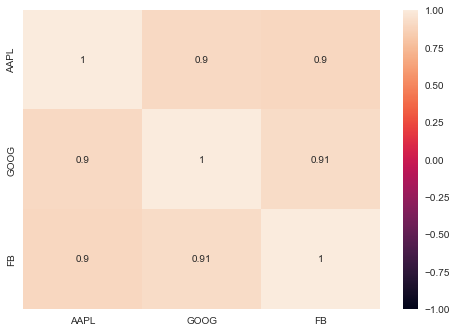

In [ ]:

def plot_corr(stocks, names, col='Adj Close'):
    '''ACCEPT TWO LISTS AND A COLUMN NAME
    stocks = LIST OF OHLC DATAFRAMES
    names = LIST OF THEIR NAMES
    col = COLUMN TO COMPARE IN EACH DF
    
    RETURNS A COMPLETED HEATMAP
    '''

    correlation_matrix = pd.DataFrame(np.corrcoef([stock[col] for stock in stocks]))
    correlation_matrix.columns = names
    correlation_matrix.index = names
    sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1)
    plt.show()
    
# ### example using get_stock():
a=get_stock('AAPL', start=start)
b=get_stock('GOOG', start=start)
c=get_stock('FB', start=start)
### list of stock objects
my_stocks = [a,b,c]
### list of stock names
tickers = [x[0] for x in my_stocks]
### list of OHLC dataframes
stock_frames = [x[1] for x in my_stocks]
#plot correlation coefficient heatmap
plot_corr(stocks=stock_frames, names=tickers)




# API FUNCTIONS


In [ ]:
IEX_CLOUD_API_TOKEN = 'Tpk_51288d3483474f5d8b80a8764c92eef5'

## test/token API key available free. All rights reserved? Can I say that?


In [ ]:
def batch_API_call(symbol_string,
                   endpoint,
                   n=100,
                   token=IEX_CLOUD_API_TOKEN
                  ):
    '''Accept :
        
        a string of stocknames; max n names per call; a dictionary of endpoints 
    
    
       Functionality :
       
        parse each endpoint from the calls dictionary and yield the raw data (n-stocks worth of dictionaries 
        (in a list or dict?)
        
           
            
       Return  :
       
       yield a dictionary of endpoint names for each stock in the call.

    '''
#     ",".join(endpoints)
    
    
    # api call for a single url
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch/?types={endpoint}&symbols={symbol_string}&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()

#     print(data.status_code)
    return data

# b = []
# for string in batches:
#     _ = batch_API_call(string)
#     b.append(_)

In [ ]:
# IEX_CLOUD_API_TOKEN = 'Tpk_51288d3483474f5d8b80a8764c92eef5'

def get_stock_info(ticker, endpoint, api_key=IEX_CLOUD_API_TOKEN):
    ticker = ticker
    endpoint = endpoint

    # api call for a single url
    api_url = f'https://sandbox.iexapis.com/stable/stock/{ticker}/{endpoint}?token={IEX_CLOUD_API_TOKEN}'

    data = requests.get(api_url)
#     print(data.status_code)
    return data.json()

### Example -- Try these out !

# get_stock_info('AAPL', 'advanced-stats')

get_stock_info('AAPL', 'quote').keys()

# get_stock_info('AAPL', 'stats')


### 'quote' endpoint API keys.

dict_keys(['avgTotalVolume', 'calculationPrice', 'change', 'changePercent', 'close', 'closeSource', 'closeTime', 'companyName', 'currency', 'delayedPrice', 'delayedPriceTime', 'extendedChange', 'extendedChangePercent', 'extendedPrice', 'extendedPriceTime', 'high', 'highSource', 'highTime', 'iexAskPrice', 'iexAskSize', 'iexBidPrice', 'iexBidSize', 'iexClose', 'iexCloseTime', 'iexLastUpdated', 'iexMarketPercent', 'iexOpen', 'iexOpenTime', 'iexRealtimePrice', 'iexRealtimeSize', 'iexVolume', 'lastTradeTime', 'latestPrice', 'latestSource', 'latestTime', 'latestUpdate', 'latestVolume', 'low', 'lowSource', 'lowTime', 'marketCap', 'oddLotDelayedPrice', 'oddLotDelayedPriceTime', 'open', 'openTime', 'openSource', 'peRatio', 'previousClose', 'previousVolume', 'primaryExchange', 'symbol', 'volume', 'week52High', 'week52Low', 'ytdChange', 'isUSMarketOpen'])

In [ ]:
def parse_data(symbol, cache=pd.DataFrame(), token=IEX_CLOUD_API_TOKEN):
    # define the endpoints
    endpoints = ['quote', 'stats', 'advanced-stats']
    
    
    my_columns = [
                'Ticker',
                '1-Year Price Return',
                '6-Month Price Return',
                '3-Month Price Return',
                '1-Month Price Return', 
                'Price',
                'P/E Ratio',
                'P/B Ratio',
                'P/S Ratio',
                'Ent Val', 
                'EBITDA',
                'Gross Profit',
                ]

#********************************************************

    # for each endpoint, make a list of stats
    # quote_stats = ['year1ChangePercent', 'month1ChangePercent', 'month3ChangePercent', 'month6ChangePercent']
    # stats_stats = []
    # advanced_stats = []
#********************************************************
    quote = get_stock_info(symbol, 'quote')
    stats = get_stock_info(symbol, 'stats')
    advanced = get_stock_info(symbol, 'advanced-stats')

    my_series = pd.Series([
                        symbol,
                        stats['year1ChangePercent'],
                        stats['month6ChangePercent'],
                        stats['month3ChangePercent'],
                        stats['month1ChangePercent'],
                        quote['latestPrice'],
                        quote['peRatio'], 
                        advanced['priceToBook'],
                        advanced['priceToSales'],
                        advanced['enterpriseValue'],
                        advanced['EBITDA'],
                        advanced['grossProfit'],
			],
                    index=my_columns)

    cache = cache.append(my_series,
                ignore_index=True)
    return cache

#### Example

mydf = parse_data('AAPL')

# mydf = parse_data('FB', mydf)

mydf


,Ticker,1-Year Price Return,6-Month Price Return,3-Month Price Return,1-Month Price Return,Price,P/E Ratio,P/B Ratio,P/S Ratio,Ent Val,EBITDA,Gross Profit
0,AAPL,0.312228,0.213887,0.18119,-0.009915,177.8,30.06,40.43,7.91,2.997723e+12,1.328602e+11,1.664412e+11



#### Technical Indicators


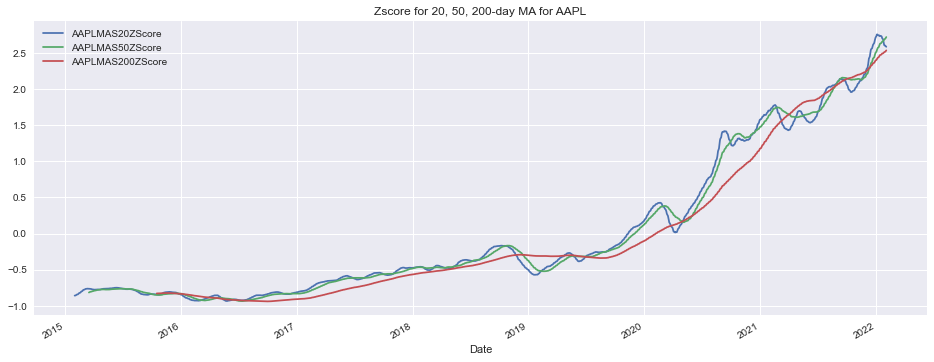

In [ ]:

def zscore(col, name=None):
    '''return the normalized standard deviation of a series'''
    output = (col-col.mean())/np.std(col)
    if col.name:
        name = col.name
        output.name = f'{name}ZScore'
    return output


# ### example
a=get_stock('AAPL', start='2015-01-01')
plt.figure(figsize=(16,6))
plt.title('Zscore for 20, 50, 200-day MA for AAPL')
zscore(add_ma(a[1], name=a[0])).plot()
zscore(add_ma(a[1],  50, name=a[0])).plot()
zscore(add_ma(a[1], 200, name=a[0])).plot()
plt.legend();


In [ ]:
def SMA(data, period=30, column='Adj Close'):
    return data[column].rolling(window=period).mean()

def EMA(data, period=20, column='Adj Close'):
    return data[column].ewm(span=period, adjust=False).mean()

# <!-- Moving Average Convergence/Divergence -->
def MACD(data, period_long=26, period_short=20, period_signal =9 , column='Adj Close'):
    # calculate the EMA for short period
    shortEMA = EMA(data=data, period=period_short, column=column)
    # calculate the EMA for long period
    longEMA = EMA(data=data, period=period_long, column=column)
    
    # Calculate the MACD
    MACD = shortEMA - longEMA
#     print(MACD)

    data['MACD'] = MACD
    signal_line = EMA(data, period_signal, column='MACD')

    data['signal_line'] = signal_line
    
    return data

def RSI(data, period=14, column='Adj Close'):
    delta = data[column].diff(1)
    delta[0] = delta[1]
    up = delta.copy()
    down = delta.copy()
    up[up<0] = 0
    down[down>0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = abs(SMA(data, period, column = 'up'))
    AVG_Loss = abs(SMA(data, period, column = 'down'))
    
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0/(1.0 + RS))
    
    data['RSI'] = RSI
    
    return data


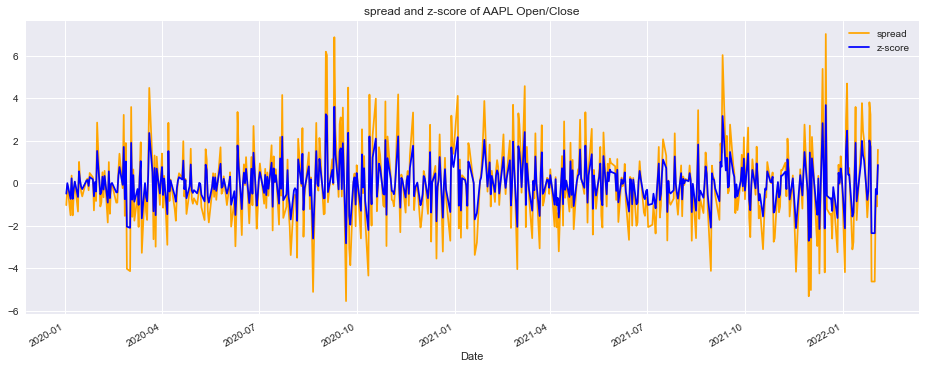

In [ ]:

def return_spread(stock1, stock2):
    '''return the spread of 2 series as a series'''
    spread = stock1 - stock2
    return spread

# ## example
# a=get_stock('AAPL', start)
# spread = return_spread(a[1]['Open'], a[1]['Close'])
# spread.plot(figsize=(16,6), c='orange', label='spread')
# plt.title(f'spread and z-score of {a[0]} Open/Close')
# zscore(spread).plot(c='blue', label='z-score')
# plt.legend()
# plt.show()



# Functions from Options Calculator 

These were some of my first attempts at calls and puts; their latest form can be found in `Understanding Options Contracts.ipynb`


## Call

In [ ]:

def call(premium, strike, market_price, buy=True, verbose=False): 
    '''a call contract object
    accepts:
    premium(int): 100 * the cost of the contract
    strike(float or int): the strike price of the contract
    market_price(float or int): the current price of the stock
    
    buy(bool): whether the object should consider the contract purchased or sold, by the holder
    verbose(bool): for debugging
    '''
    
    ### The value of an options contract is composed of its initial premium + intrinsic value w.r.t. market price.
    ### the initial profit or loss upon purchasing a contract is fixed.
    ### the 
    profit = 0
    intrinsic_value = 0
    
    # The owner of a call executes their purchase order if close price is HIGHER than strike price 
    # The owner wants to buy for cheaper!  
    # Intrinsic value is difference between strike and close price
    # Intrinsic value is 0 when the strike price equals the market_price.
    
    if market_price > strike:
        # purchase triggers
        intrinsic_value = (market_price - strike) * 100 # positive value
    else:
        # market is less than strike
        intrinsic_value = 0
    
    # if this portfolio purchased the call
    if buy==True:
        # lose the premium
        profit -= premium
        # gain the intrinsic value
        profit += intrinsic_value
        # TODO: also return the value of the shares you purchased to cover?
        
    
    # if this portfolio wrote/sold this call:
    elif buy !=True:
        # you've already gained the premium;
        profit += premium
        
        # but now you lose the intrinsic_value.
        profit -= intrinsic_value
  
    if verbose == True:
    
#         print(f'{profit} is the immediate return of this transaction')
        print(f'${intrinsic_value} is the intrinsic value of this ${strike} call at ${market_price}/share price.\nIt was worth {premium} at sale')
        print(f'{profit} is the net profit or loss.')

    return profit

### Example

# call(115, 12.50, 10, buy=False, verbose=True)
# call(115, 12.50, 12.50, buy=False, verbose=True)
# call(115, 12.50, 15, buy=False, verbose=True)
# call(115, 12.50, 17.5, buy=False, verbose=True)


## Put

In [ ]:

def put(premium, strike, market_price, buy=True, verbose=False):
    
    # container for value at time of [market_price]
    profit = 0
    
    # intrinsic value is difference between strike and end_price
    intrinsic_value = 0
    
    # this contract will execute if market is LOWER than strike    
    if market_price < strike:
        # it's value is the surplus of 
        intrinsic_value = (market_price - strike) * -100
    
    if buy==True:
        # lose the premium
        profit -= premium
        # gain the intrinsic_value
        profit += intrinsic_value
           
    elif buy !=True:
        # gain the premium
        profit += premium
        
        # lose the intrinsic_value
        profit -= intrinsic_value 
  
    if verbose == True:
#         print(f'{premium} is the immediate return of this transaction')
        print(f'{intrinsic_value} is the intrinsic value of this ${strike} put at ${market_price}. It was worth {premium} at sale.')
        print(f'{profit} is the net profit or loss.')

    return profit

# put(390, 12.5, 5, buy=False, verbose=True)
# put(390, 12.5, 7.5, buy=False, verbose=True)
# put(390, 12.5, 10, buy=False, verbose=True)
# put(390, 12.5, 12.5, buy=False, verbose=True)
# put(390, 12.5, 15, buy=False, verbose=True)

def buy_call(premium, strike, end_price):
    return call(premium, strike, end_price, buy=True)

def sell_call(premium, strike, end_price):
    return call(premium, strike, end_price, buy=False)

def buy_put(premium, strike, end_price):
    return put(premium, strike, end_price, buy=True)

def sell_put(premium, strike, end_price):
    return put(premium, strike, end_price, buy=False)




# WIP: End of the line

##### Functions for TensorFlow/Keras;

I haven't really gotten to the point where I would feel comfortable using keras -- or deep learning generally -- the way I want to.

In [ ]:
def make_time(df, high='High', low='Low', time='week', start=0):
    
    # assign starting values to first column values
    
    curr_max = df[high][start]
    curr_min = df[low][start]
    curr_week = df[time][start]
    
    # create a frame for comparison
    frame = []

    for idx, val in df.iterrows():
        
        if val[time] != curr_week:
            # reset everything on new time column value. --> to 'Open'?
            curr_max=df.loc[idx, high]
            curr_min=df.loc[idx, low]
            curr_week = val[time]
            frame = []
            
        # otherwise and after; append the row to frame
        frame.append(df.loc[idx, :])
        
        # conditionally, change the current max and min:
        if val[high] > curr_max:
            curr_max = val[high]

        if val[low] < curr_min:
            curr_min = val[low]
            
    return pd.DataFrame(frame) # return the last time-window of data.

### Example
make_time(df) # 

NameError: name 'df' is not defined

In [ ]:
def window_label(df, n, return_last=False):
    '''yield consecutive slices from df
    of row-size n.
    
    if 'return_last' is TRUE:
        the window's last value will be returned as the second value of a tuple.
        the other rows in the window will be contained in the first value of the tuple.
    '''
    for i in range(0, len(df), n):
        wdw = df[i:i+n]
        if return_last == True:
            yield wdw.iloc[:-1, :], wdw.iloc[-1, :]
        else:
            yield wdw

#### Example
next(window_label(data, 4, return_last=True))[0] # the second tuple index is the fourth row; the 'label' or target.

NameError: name 'data' is not defined

In [ ]:
# CCW = get_stock('CCW.V', '2020-01-01')
# name = CCW[0]
# df = CCW[1]

# # volume = df.pop('Volume')
# add_ma(df, 50, add_col=True)
# add_ma(df, 200, kind='e', add_col=True)

# find_gold(df, 'SMA50', 'EMA200')

# fig, axs = plt.subplots(figsize=(24,18))
# fig.suptitle(f'{name}')
# axs.plot(df['Adj Close'])
# axs.scatter(find_gold(df, 'SMA50', 'EMA200'), find_gold(df, 'SMA50', 'EMA200'))
# # axs.bar(CCW.index, volume)
# # plt.legend()
# # Hide x labels and tick labels for all but bottom plot.

# plt.show()

# # CCW.plot